## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## In this section the camera will be calibrated and undistorted images will be created

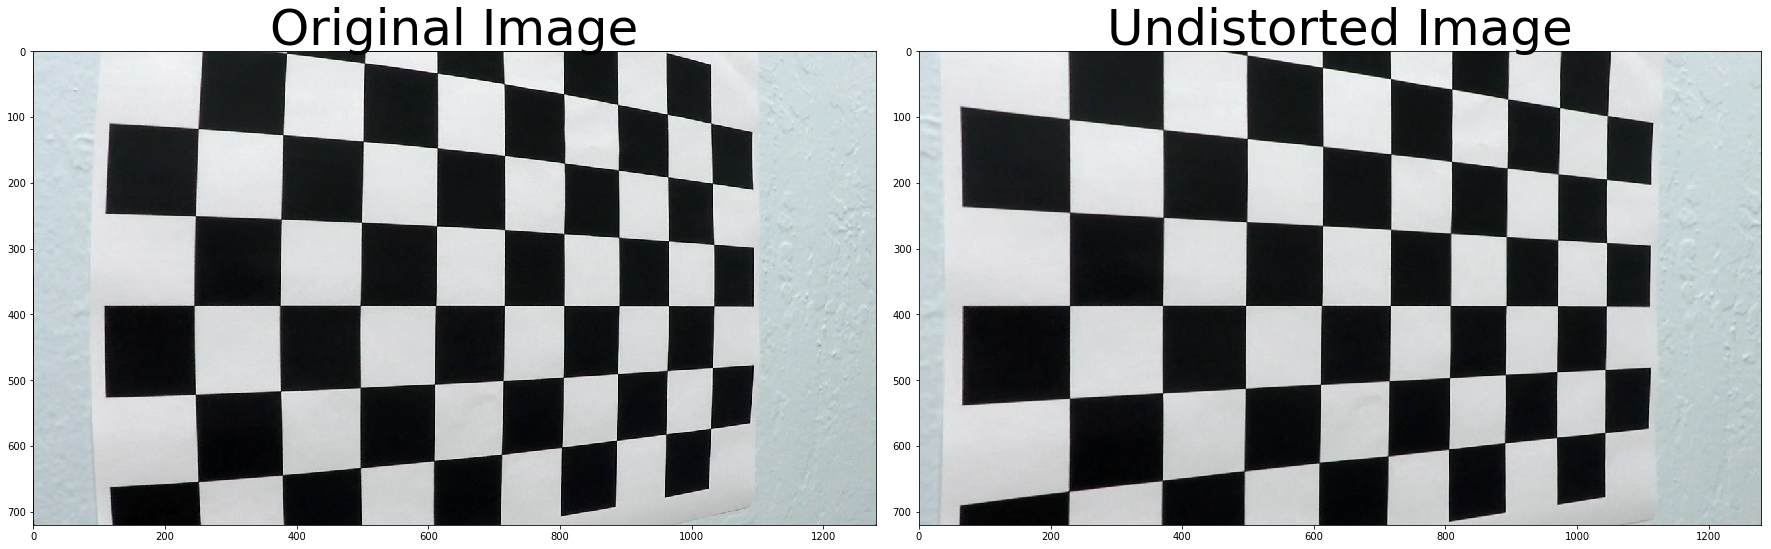

In [2]:
%matplotlib inline
#A helper function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

#mtx is the conversion matrix and dit is the distortion matrix
# Use cv2.calibrateCamera()
gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera (objpoints, imgpoints, gray.shape[::-1], None, None)

def cal_undistort(img, objpoints, imgpoints, mtx):
    # Use cv2.undistort()
    undist = cv2.undistort (img, mtx, dist, None, mtx)
    return undist

#calling the helper function on an example chessboard picture
image_example = cv2.imread('../camera_cal/calibration5.jpg')
undistorted_example = cal_undistort (image_example, objpoints, imgpoints, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_example)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_example)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Now the cal_undistort() function can be used to undistort any image taken by this camera, also images of roads like the following example

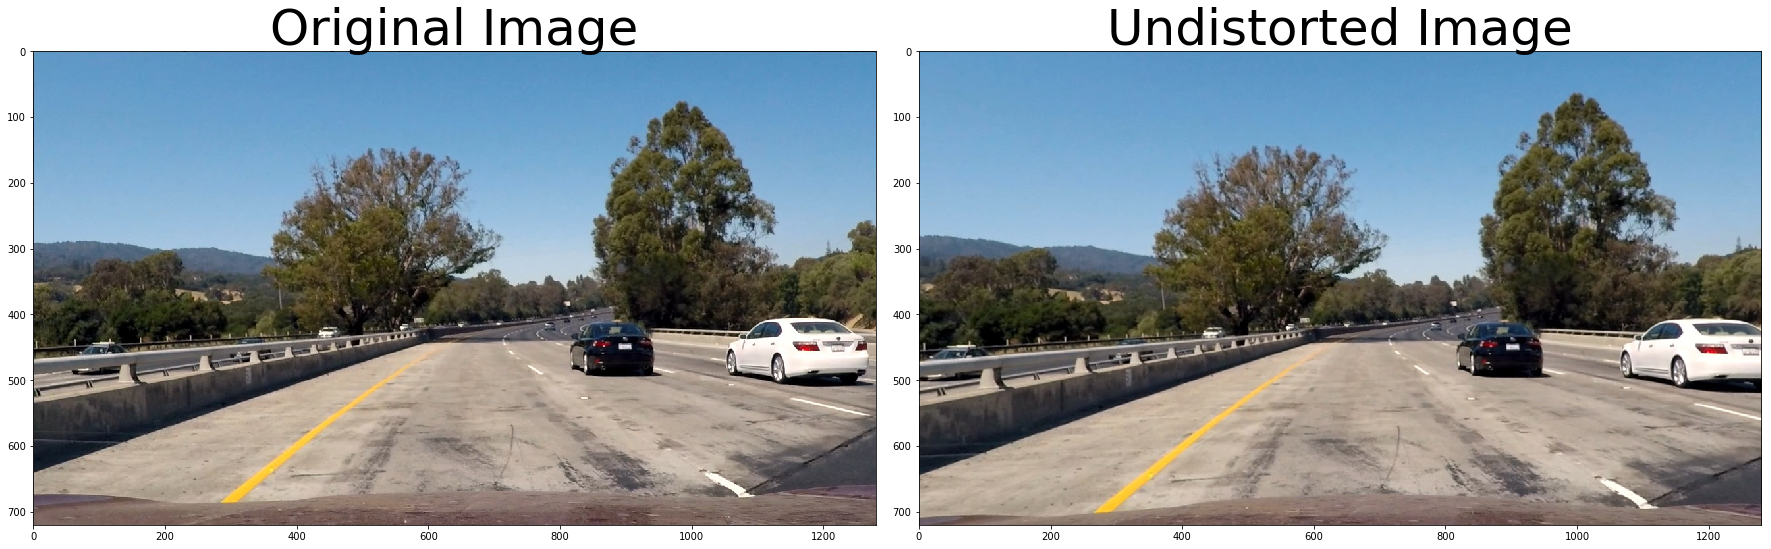

In [12]:
image_example = cv2.imread('../test_images/test1.jpg')
undistorted_example = cal_undistort (image_example, objpoints, imgpoints, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image_example,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undistorted_example, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## In this section filters for gradients and the direction of it and also color filters for HLS space are created and used to find the best posible space with their combination to find the lane lines

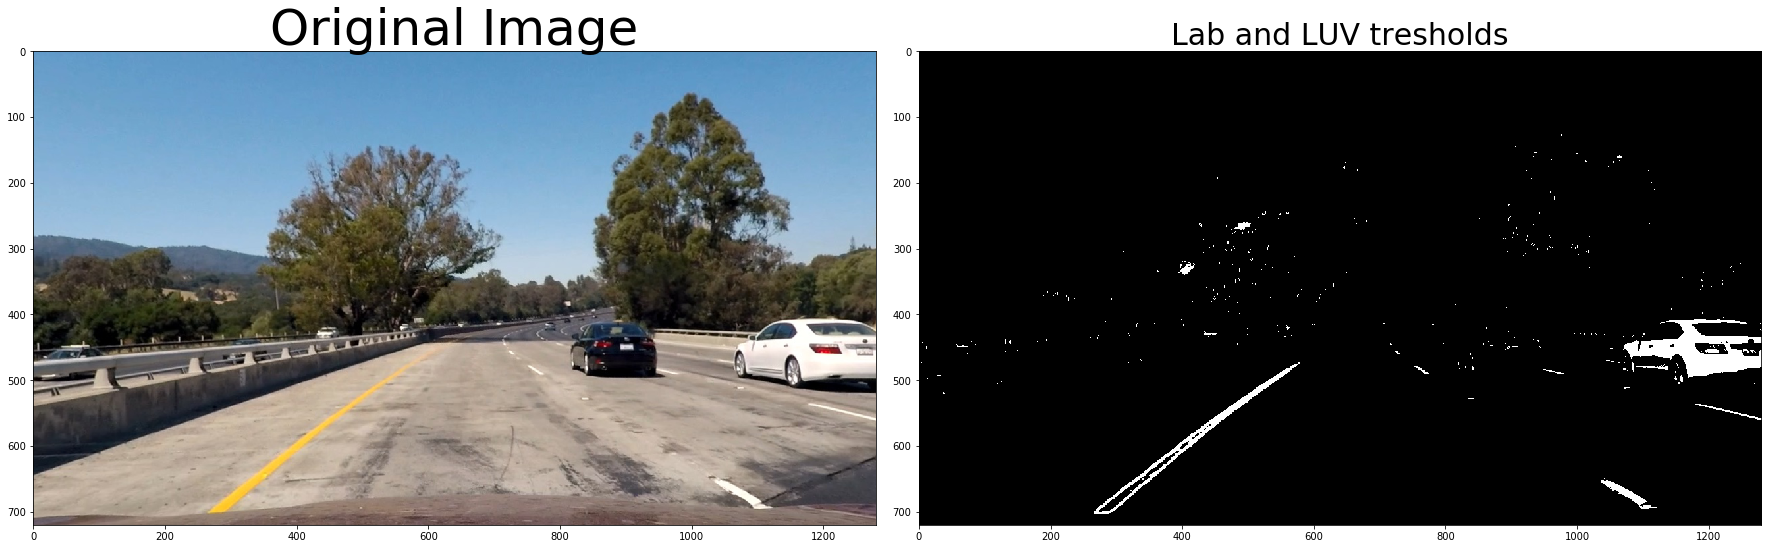

In [13]:
import matplotlib.image as mpimg
#3 helper functions are defined to take the gradient in x and y direction, the magnitude of the derivative and also
# the direction of the gradient. In the end a combination of these criterias will be used to find the best result

def abs_sobel_thresh (img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobel = cv2.Sobel (gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel (gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        print ('Eror value for orient')
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute (sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8 (255 * abs_sobel / np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like (scaled_sobel)
    binary_output [(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel (gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel (gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt (np.square(sobelx) + np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8 (255 * abs_sobel / np.max (abs_sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like (scaled_sobel)
    binary_output [(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
 
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel (gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel (gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt (sobelx ** 2)
    abs_sobely = np.sqrt (sobely ** 2)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like (grad_dir)
    binary_output [(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor (img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls [:,:,2]
    binary_output = np.zeros_like (s_channel)
    # 3) Return a binary image of threshold result
    binary_output [(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    #binary_output = np.copy(img) # placeholder line
    return binary_output
def luv_select (img, thresh=(0,255)):
    luv = cv2.cvtColor (img, cv2.COLOR_RGB2LUV)
    l_channel = luv [:,:,0]
    binary_output = np.zeros_like (l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    #binary_output = np.copy(img) # placeholder line
    return binary_output   
def lab_select (img, thresh=(0,255)):
    lab = cv2.cvtColor (img, cv2.COLOR_RGB2LAB)
    b_channel = lab [:,:,2]
    binary_output = np.zeros_like (b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    #binary_output = np.copy(img) # placeholder line
    return binary_output   


#Define a helper function that apploes all the filters on a image and returns the final filtered image
def applyFilters (image, ksize, threshxy, threshMag, threshDir,threshColor):
# Apply each of the thresholding functions with the help of the helper functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel = ksize, thresh = threshxy)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel = ksize, thresh = threshxy)
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh = threshMag)
    dir_binary = dir_threshold(image, sobel_kernel = ksize, thresh = threshDir)
    hls_binary = hls_select (image, thresh = threshColor)
    luv_binary = luv_select (image, thresh = (225, 255))
    lab_binary = lab_select (image, thresh = (155, 200))

    combined = np.zeros_like(dir_binary)
    combined [(lab_binary == 1) | (luv_binary == 1) | ((gradx == 1)& (hls_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) &  (((mag_binary == 1) & (dir_binary == 1) | hls_binary == 1)) & luv_binary == 1 & lab_binary == 1] = 1
    return combined

# Choose a Sobel kernel size and other parameters for apply filters
ksize = 3
threshxy = (30,100)
threshMag = (30,100)
threshDir = (0.7, 1.3)
threshColor = (90,255)

#Reading in an example image
image = cv2.cvtColor(undistorted_example,cv2.COLOR_BGR2RGB) #mpimg.imread ('../test_images/straight_lines1.jpg')

combined = applyFilters (image, ksize, threshxy, threshMag, threshDir, threshColor)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Lab and LUV tresholds', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## In the below code section the prespective of the image is changed to bird-eye view such that the image can be seen from above and the lane lines become aproximately parallel to each other

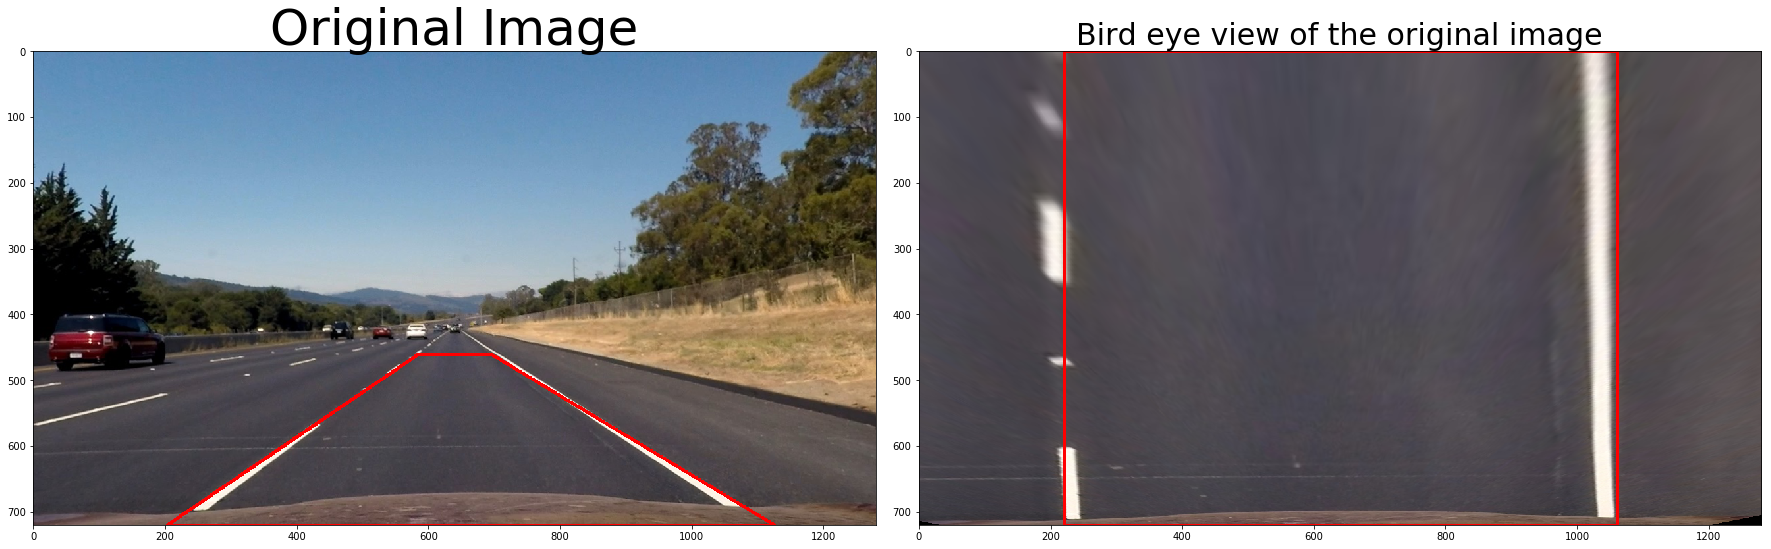

In [14]:
import math
#Define a helper function to transform the undistorted input image's perspective to bird eye view
def TransofmToBirdeyeView (img):
    #Defining source and destination points to get the transormation matrix
    #src are the points on the original image
    img_size = img.shape
    src = np.float32(
    [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
    [((img_size[1] / 6) - 10), img_size[0]],
    [(img_size[1] * 5 / 6) + 60, img_size[0]],
    [(img_size[1] / 2 + 70), img_size[0] / 2 + 100]]) #+55 to +80
    
    #dst are the points corresponding on the transformed image
    dst = np.float32(
    [[(img_size[1] / 4 - 100), 0],
    [(img_size[1] / 4 - 100), img_size[0]],
    [(img_size[1] * 3 / 4 +  100), img_size[0]],
    [(img_size[1] * 3 / 4 + 100), 0]])
    
    M = cv2.getPerspectiveTransform (src, dst)
    Minv = cv2.getPerspectiveTransform (dst, src)
    warped = cv2.warpPerspective (img, M, (img.shape[1], img.shape[0]), flags= cv2.INTER_LINEAR)
    return warped, M, Minv


#Testing the helper function on one of the test images provided

img = mpimg.imread ('../test_images/straight_lines2.jpg')#cv2.imread ('../test_images/test2.jpg')
#undistorting the read image
undistort = cal_undistort (img, objpoints, imgpoints, mtx)
#changing the perspective of the image
img_birdeye, M, Minv = TransofmToBirdeyeView(undistort)

# Plot the result
img_size = img.shape
cv2.line(undistort, (math.floor(img_size[1] / 2) - 55, math.floor(img_size[0] / 2) + 100), (math.floor(img_size[1] / 6) - 10, img_size[0]), [255,0,0],4)
cv2.line(undistort, (math.floor(img_size[1] / 6) - 10, img_size[0]), (math.floor(img_size[1] * 5 / 6) + 60, img_size[0]), [255,0,0],4)
cv2.line(undistort, (math.floor(img_size[1] * 5 / 6) + 60, img_size[0]),(math.floor(img_size[1] / 2) + 55, math.floor(img_size[0] / 2) + 100),[255,0,0],4)
cv2.line(undistort, (math.floor(img_size[1] / 2) - 55, math.floor(img_size[0] / 2) + 100), (math.floor(img_size[1] / 2) + 55, math.floor(img_size[0] / 2) + 100), [255,0,0],4)



cv2.line (img_birdeye, (math.floor(img_size[1] / 4 - 100), 0),(math.floor(img_size[1] / 4 - 100), img_size[0]),[255,0,0], 4)
cv2.line (img_birdeye, (math.floor(img_size[1] / 4 - 100), img_size[0]),(math.floor(img_size[1] * 3 / 4 + 100), img_size[0]),[255,0,0], 4)
cv2.line (img_birdeye, (math.floor(img_size[1] * 3 / 4 + 100), img_size[0]),(math.floor(img_size[1] * 3 / 4 + 100), 0),[255,0,0], 4)
cv2.line (img_birdeye, (math.floor(img_size[1] / 4 - 100), 0 ),(math.floor(img_size[1] * 3 / 4 + 100), 0),[255,0,0], 4)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistort)

ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_birdeye)

ax2.set_title('Bird eye view of the original image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    

## Detecting the lines in the filtered bird-eye-view threshold image

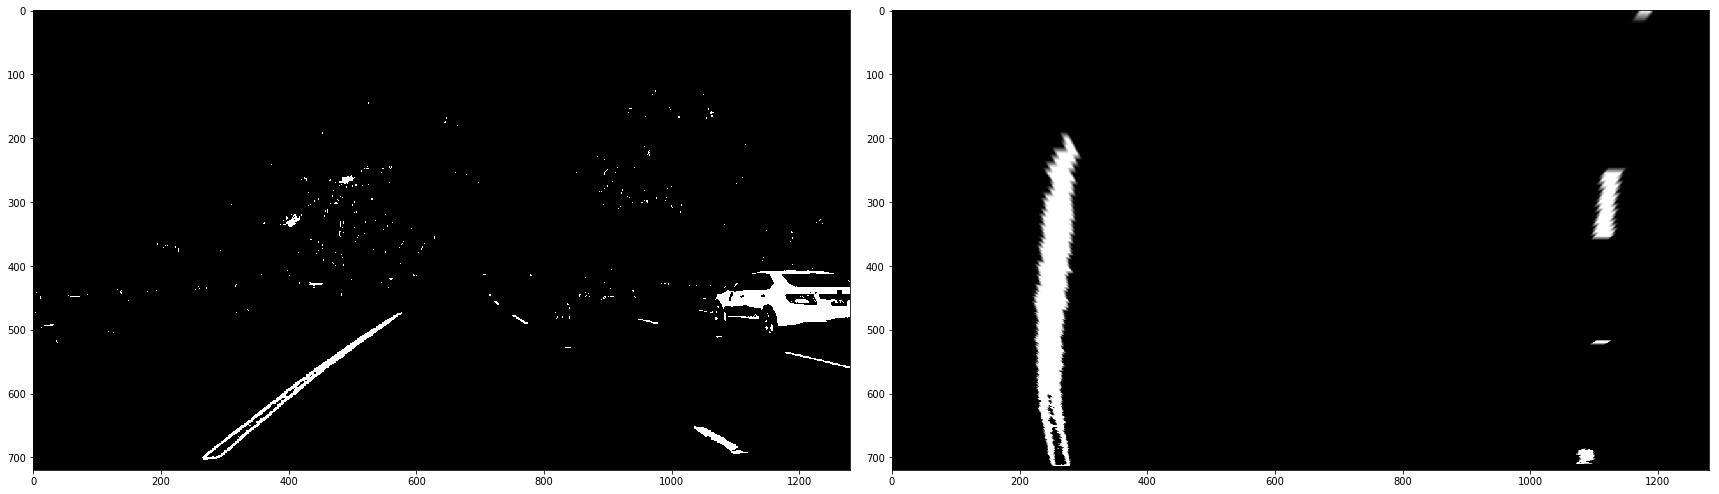

In [15]:
combined_otherview, M, Minv = TransofmToBirdeyeView (combined)


#combined_otherview = cv2.cvtColor (combined_otherview, cv2.COLOR_GRAY2RGB)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap = 'gray')


ax2.imshow(combined_otherview, cmap = 'gray')



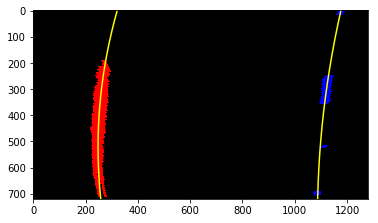

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#A helper function that receives as input an warped image and returns the image with lanes detected and the fitted
#polynomials for the result
def laneDetection (binary_warped):
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,0.8,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,0.8,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, lefty, righty, leftx, rightx

binary_warped = np.copy(combined_otherview)
out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, lefty, righty, leftx, rightx = laneDetection (binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

## Calculating the curvature and the car distance to the center of the lane

In [17]:
#A helper function that receives the binary warp and calculates the lane curvature
def laneCurvature (img):
    out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, lefty, righty, leftx, rightx = laneDetection (img)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    #calculation of distance of car to center
    offset_right = (right_fit[0] * img.shape[0] ** 2) + (right_fit[1] * img.shape[0]) + right_fit[2]
    offset_left = (left_fit[0] * img.shape[0] ** 2) + (left_fit[1] * img.shape[0]) + left_fit[2]
    distance_to_center = (offset_right + offset_left)/2.0 - 640
    distance_to_center = distance_to_center * 3.7 / 700 #changing the distance to m
    
    
    
    return out_img, ploty, left_fitx, right_fitx, left_curverad, right_curverad, distance_to_center
#testing the function
binary_warped = np.copy(combined_otherview)
print (laneCurvature (binary_warped)[4:7])

(611.55728790687022, 1157.2890179462684, 0.17427846118868656)


## Combining all the steps on a single image and getting the detected lane lines

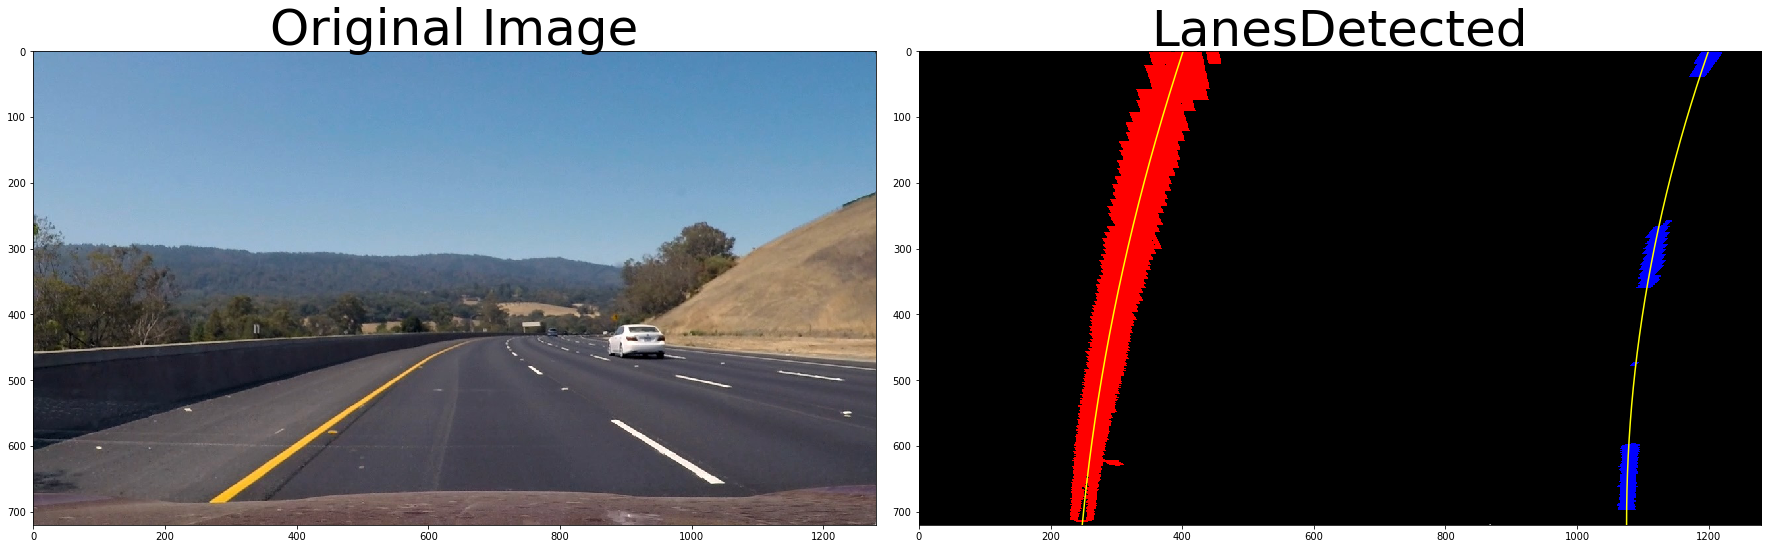

In [18]:
#Calibrating the camera
#Reading in the image
#Undistorting the image
#Applying the filters and getting a warped image out 
#Applying the perspective transformation to get a bird-eye-view perspective
#Detect lines and find curvature
#For all of the above steps a function is defined called findLanes that gets as input an distorted image as input
# and returns the bird-eye-view transformed image and fited plynomials to the lane line
 
def findLanes (image):
    undistorted_example = cal_undistort (image, objpoints, imgpoints, mtx)
    # Choose a Sobel kernel size and other parameters for apply filters
    ksize = 3
    threshxy = (10,100)
    threshMag = (30,100)
    threshDir = (0.7, 1.3)
    threshColor = (70,255)

    #Reading in an example image
    image = cv2.cvtColor(undistorted_example,cv2.COLOR_BGR2RGB)

    combined = applyFilters (image, ksize, threshxy, threshMag, threshDir, threshColor)
    combined_otherview, M, Minv = TransofmToBirdeyeView (combined)
    binary_warped = np.copy(combined_otherview)
    out_img, ploty, left_fitx, right_fitx, left_curverad, right_curverad,dist_to_center = laneCurvature (binary_warped)
    return out_img, combined_otherview, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv, dist_to_center
 
    
#Testing the pipeline
image_example = cv2.imread('../test_images/test3.jpg')
out_img, combined_otherview, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv, dist_to_center = findLanes (image_example)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image_example,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('LanesDetected', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
#pl.xlim(0, 1280)
#plt.ylim(720, 0)

## Transforming the image back to original state and creating the final output

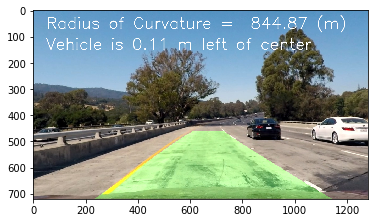

In [19]:
#Helper function that receives the finished warp image and the fitted polynomials and turns them back into the 
#undistorted original image
def backTransformation (original_image, warped, ploty, left_fitx, right_fitx, Minv, curvature, dist_to_center):
    # Create an image to draw the lines on
   
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    

    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    plt.imshow (color_warp)


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature =  ' + str("%.2f" %curvature) + ' (m)'
    if dist_to_center < 0:
        dist_text = str ("%.2f" % abs(dist_to_center)) + ' m right'
    else:
        dist_text = str ("%.2f" % dist_to_center) + ' m left'
    text2 = 'Vehicle is ' + dist_text + ' of center'
    cv2.putText(result, text, (50, 70), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (50,150), font, 2, (255,255,255), 2, cv2.LINE_AA)
    return result
warped = np.copy (combined_otherview)
result = backTransformation(undistorted_example,warped, ploty, left_fitx, right_fitx, Minv,(left_curverad + right_curverad) / 2, dist_to_center)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

## Applying the above pipeline to video frames

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [11:56<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 14min 13s, sys: 15.9 s, total: 14min 29s
Wall time: 11min 59s


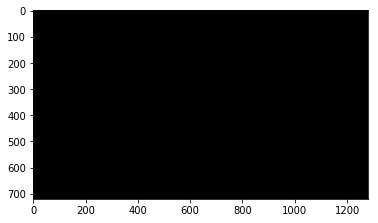

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    undistorted = cal_undistort (image, objpoints, imgpoints, mtx)
    out_img, combined_otherview, ploty, left_fitx, right_fitx, left_curverad, right_curverad,Minv, dist_to_center = findLanes (image)
    result = backTransformation(undistorted, combined_otherview, ploty, left_fitx, right_fitx, Minv, (left_curverad + right_curverad)/2.0, dist_to_center)
    return result
white_output = '../project_video_output.mp4'

clip1 = VideoFileClip("../project_video.mp4")


white_clip = clip1.fl_image(process_image) 

%time white_clip.write_videofile(white_output, audio=False)

